In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.finance import candlestick_ohlc
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
from scipy import stats
import pytz
import pandas_market_calendars as mcal
import datetime
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import statsmodels.api as sm
from statsmodels.formula.api import ols
from IPython.display import display
from time import sleep
pd.set_option('mode.chained_assignment', None)

In [2]:
#We hack the NYSE Calendar extending the close until 4:15
class CMERTHCalendar(mcal.exchange_calendar_nyse.NYSEExchangeCalendar):
    @property
    def close_time(self):
        return datetime.time(16, 15)

In [3]:
'''Load 1min bar data exported from Ninjatrader.
   Convert to 5min RTH bars.'''
data = pd.read_csv('ES.csv',delimiter=';',header=None, index_col='date', parse_dates=['date'],
                    names=['date','open','high','low','close','volume'])
data.index = data.index.tz_localize('UTC')
data = data.tz_convert('US/Eastern')
'''five_min = data.groupby(pd.TimeGrouper(freq="5min", closed='right', label="right")).aggregate({
        'volume': sum,
        'open' : 'first',
        'close' : 'last',
        'high' : max,
        'low' : min
    })
five_min = five_min.between_time('9:30','16:15',include_start=False)'''
# Get market calendar
#nyse = mcal.get_calendar('NYSE') 
nyse = CMERTHCalendar()
schedule = nyse.schedule(start_date=data.index.min(), end_date=data.index.max())

#Filter out those bars that occur during RTH
data['dates'] = pd.to_datetime(data.index.to_datetime().date)
data['valid_date'] = data['dates'].isin(schedule.index)
data['valid_time'] = False
data.loc[data['valid_date'] & (data.index > schedule.loc[data['dates'],'market_open']) & (data.index <= schedule.loc[data['dates'],'market_close']), 'valid_time'] = True
df = data[data['valid_time'] == True]
df = df.drop(['dates','valid_date','valid_time'], axis=1)

#Create 5min bars
bt_five = mcal.date_range(schedule, frequency='5min').tz_convert('US/Eastern')
five_min = df.groupby(bt_five[bt_five.searchsorted(df.index)]).aggregate({
        'volume': sum,
        'open' : 'first',
        'close' : 'last',
        'high' : max,
        'low' : min
    })

#Create 60min bars
bt_sixty = mcal.date_range(schedule, frequency='60min').tz_convert('US/Eastern')
sixty_min = df.groupby(bt_sixty[bt_sixty.searchsorted(df.index)]).aggregate({
        'volume': sum,
        'open' : 'first',
        'close' : 'last',
        'high' : max,
        'low' : min
    })

#Create 15min bars
bt_fifteen = mcal.date_range(schedule, frequency='15min').tz_convert('US/Eastern')
fifteen_min = df.groupby(bt_fifteen[bt_fifteen.searchsorted(df.index)]).aggregate({
        'volume': sum,
        'open' : 'first',
        'close' : 'last',
        'high' : max,
        'low' : min
    })

#Create daily bars
bt_daily = mcal.date_range(schedule, frequency='1D').tz_convert('US/Eastern')
daily = df.groupby(bt_daily[bt_daily.searchsorted(df.index)]).aggregate({
        'volume': sum,
        'open' : 'first',
        'close' : 'last',
        'high' : max,
        'low' : min
    })

/home/vagrant/anaconda3/lib/python3.6/site-packages/pandas/tseries/index.py:123: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  result[o_mask] = nat_result


In [8]:
##We do some data munging and filter on trading days....
#five_min['timestamp'] = five_min.index
five_min['bartimer'] = five_min.index - five_min.index.normalize() - pd.to_timedelta("9:30:00")
five_min['barcount'] = (five_min['bartimer'] / pd.Timedelta('1 minute') / 5).astype(int)

#five_min.index = five_min.index.normalize()
#nyse = mcal.get_calendar('NYSE')
#trading_days = nyse.valid_days(start_date=five_min.index.min(), end_date=five_min.index.max(),
#                               tz='US/Eastern')
#five_min['date'] = five_min.indexw
#five_min.set_index('timestamp',inplace=True)

#Calculate EMA's
five_min['ema'] = five_min['close'].ewm(span=20, min_periods=20).mean()
sixty_min['ema'] = sixty_min['close'].ewm(span=20, min_periods=20).mean()
daily['ema'] = daily['close'].ewm(span=20, min_periods=20).mean()
five_min['60min_ema'] = np.nan
five_min['60min_ema'].loc[sixty_min.index] = sixty_min['ema']
five_min['60min_ema'] = five_min['60min_ema'].fillna(method='ffill')
fifteen_min['ema'] = fifteen_min['close'].ewm(span=20, min_periods=20).mean()
five_min['15min_ema'] = np.nan
five_min['15min_ema'].loc[fifteen_min.index] = fifteen_min['ema']
five_min['15min_ema'] = five_min['15min_ema'].fillna(method='ffill')

In [106]:
#trading_days = bt_daily[(bt_daily > "2015-10-01") & 
         #(bt_daily < "2016-10-01")].to_datetime().strftime('%Y-%m-%d').tolist()
one_percent_up_days = daily[(daily['close'] - daily['open'])/ daily['open'] >= .01].index
one_percent_down_days = daily[(daily['close'] - daily['open'])/ daily['open'] <= -.01].index
rng = (daily['high'] - daily['low'])/3
bull_trend_days = daily[(daily['close'] > daily['high'] - rng) & (daily['open'] < daily['low'] + rng)].index
trading_days = bull_trend_days[bull_trend_days > "2015-03-01"].to_datetime().strftime('%Y-%m-%d').tolist()
daily.index

DatetimeIndex(['2005-09-07 16:15:00-04:00', '2005-09-08 16:15:00-04:00',
               '2005-09-09 16:15:00-04:00', '2005-09-12 16:15:00-04:00',
               '2005-09-13 16:15:00-04:00', '2005-09-14 16:15:00-04:00',
               '2005-09-15 16:15:00-04:00', '2005-09-16 16:15:00-04:00',
               '2005-09-19 16:15:00-04:00', '2005-09-20 16:15:00-04:00',
               ...
               '2017-10-13 16:15:00-04:00', '2017-10-16 16:15:00-04:00',
               '2017-10-17 16:15:00-04:00', '2017-10-18 16:15:00-04:00',
               '2017-10-19 16:15:00-04:00', '2017-10-20 16:15:00-04:00',
               '2017-10-23 16:15:00-04:00', '2017-10-24 16:15:00-04:00',
               '2017-10-25 16:15:00-04:00', '2017-10-26 16:15:00-04:00'],
              dtype='datetime64[ns, US/Eastern]', length=3057, freq=None)

In [9]:
def create_candlesticks(date_string):
    
    bar_dict = {}
    x = schedule.index.get_loc(date_string)
    d1 = five_min.ix[schedule.index[x - 1].to_pydatetime().strftime('%Y-%m-%d')]
    d2 = five_min.ix[date_string]
    bd = d1.iloc[-6:].append(d2)
    bar_dict['5_min'] = bd
    
    start_date = schedule.index[x - 4].to_pydatetime().strftime('%Y-%m-%d')
    bar_dict['60_min'] = sixty_min.ix[start_date:date_string]
    
    start_date = schedule.index[x - 4].to_pydatetime().strftime('%Y-%m-%d')
    bar_dict['60_min'] = sixty_min.ix[start_date:date_string]
    
    start_date = schedule.index[x - 40].to_pydatetime().strftime('%Y-%m-%d')
    bar_dict['daily'] = daily.ix[start_date:date_string]
    
    return bar_dict
    

In [10]:
# The PDF document
#pdf_pages = PdfPages('my-fancy-document.pdf')

def plot_candlesticks(plot_title, data, pdf_pages=None):
    #### CREATE SUBPLOTS ######
    #fig, ax = plt.subplots(figsize=(20,10))
    fig = plt.figure(figsize=(16,12))
    ax = plt.subplot2grid((12,16), (0,0), colspan=16, rowspan=7)
    ax_60min = plt.subplot2grid((12,16), (7,0), colspan=8, rowspan=5)
    ax_daily = plt.subplot2grid((12,16), (7,8), colspan=8, rowspan=5)
    
    ### PLOT 5 MIN CHART ####
    
    ax.patch.set(facecolor='w', edgecolor='k', linewidth=1.0)
    bardata = data['5_min']
    bardata['timestamp'] = bardata.index.to_pydatetime()
    bardata = bardata.reset_index(drop=True)
    #bardata = data['5_min'].reset_index()
    #bardata['timestamp'] = mdates.date2num(bardata['timestamp'].dt.to_pydatetime())
    #bardata['ts'] = bardata['timestamp'].dt.to_pydatetime()
    #bardata['ts'] = bardata['timestamp'].dt.to_pydatetime()
    bardata['x'] = bardata.index


    subset = bardata[['x','open','high','low','close']]
    tuples = [tuple(x) for x in subset.values]
    candlestick_ohlc(ax, tuples, width=.5, colorup='g', colordown='r', alpha=1)

    #Custom formatter for x axis
    def format_hour(x, pos=None):
        thisind = np.clip(int(x + 0.5), 0, len(bardata.index) - 1)
        return bardata['timestamp'][thisind].strftime('%I:%M')

    ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_hour))
    xticklabels = bardata['x'].iloc[5::6].tolist()
    ax.xaxis.set_major_locator(ticker.FixedLocator(xticklabels))

    rng = subset['high'].max() - subset['low'].min()
    offset = rng * 0.0375
    ax.set_ylim([subset['low'].min() - (offset+.25), subset['high'].max() + (offset+.25)])
    ax.set_xlim([subset['x'].min() - .5, subset['x'].max() + .5])


    for line in ax.xaxis.get_ticklines():
        line.set_markersize(5)
    for line in ax.yaxis.get_ticklines():
        line.set_markersize(5)
    for line in ax.yaxis.get_gridlines():
        line.set(color='gray', ls='dotted', alpha=0.5)

    #Add bar numbers to plot
    for index, row in bardata[7::2].iterrows():
        ax.annotate(str(row['barcount']), xy=(row['x'], row['low']-offset), ha='center', size=10)

    #Add moving averages
    ax.plot(bardata['x'].tolist(), bardata['ema'].tolist(), color='blue', lw=0.5)
    ax.plot(bardata['x'].tolist(), bardata['60min_ema'].tolist(), 
            color='blue', lw=0.5, ls='dashed', alpha=0.75)
    ax.plot(bardata['x'].tolist(), bardata['15min_ema'].tolist(), 
            color='blue', lw=0.5, ls='dotted', alpha=0.75)
    
    #Plot vertical lines separating trading days
    ax.axvline(bardata['x'].iloc[5], color='black', lw=0.5)
    
    #Title
    ax.set_title(plot_title, fontsize=20)
    
    #### END 5 MIN CHART ####
    
    #### PLOT 60 MIN CHART ####
    ax_60min.patch.set(facecolor='w', edgecolor='k', linewidth=1.0)
    bardata60 = data['60_min']
    bardata60['timestamp'] = bardata60.index.to_pydatetime()
    bardata60 = bardata60.reset_index(drop=True)
    bardata60['x'] = bardata60.index

    subset = bardata60[['x','open','high','low','close']]
    tuples = [tuple(x) for x in subset.values]
    candlestick_ohlc(ax_60min, tuples, width=.5, colorup='g', colordown='r', alpha=1)
    
    #Add moving averages
    ax_60min.plot(bardata60['x'].tolist(), bardata60['ema'].tolist(), color='blue', lw=0.5)
    
    #Custom formatter for x axis
    def format_date(x, pos=None):
        thisind = np.clip(int(x + 0.5), 0, len(bardata60.index) - 1)
        return bardata60['timestamp'][thisind].strftime('%b %-d')

    ax_60min.xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
    xticklabels = bardata60['x'][bardata60['timestamp'].dt.hour == 10].tolist()
    ax_60min.xaxis.set_major_locator(ticker.FixedLocator(xticklabels))
    
    for line in ax_60min.xaxis.get_ticklines():
        line.set_markersize(5)
    for line in ax_60min.yaxis.get_ticklines():
        line.set_markersize(5)
    for line in ax_60min.yaxis.get_gridlines():
        line.set(color='gray', ls='dotted', alpha=0.5)

    
    #### END 60 MIN CHART ####
    
    #### PLOT DAILY CHART ####
    ax_daily.patch.set(facecolor='w', edgecolor='k', linewidth=1.0)
    bardatad = data['daily']
    bardatad['timestamp'] = bardatad.index.to_pydatetime()
    bardatad = bardatad.reset_index(drop=True)
    bardatad['x'] = bardatad.index

    subset = bardatad[['x','open','high','low','close']]
    tuples = [tuple(x) for x in subset.values]
    candlestick_ohlc(ax_daily, tuples, width=.5, colorup='g', colordown='r', alpha=1)
    
    #Add moving averages
    ax_daily.plot(bardatad['x'].tolist(), bardatad['ema'].tolist(), color='blue', lw=0.5)
    
    #Custom formatter for x axis
    def format_date(x, pos=None):
        thisind = np.clip(int(x + 0.5), 0, len(bardatad.index) - 1)
        return bardatad['timestamp'][thisind].strftime('%b %-d')

    ax_daily.xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
    xticklabels = bardatad['x'].iloc[::5].tolist()
    ax_daily.xaxis.set_major_locator(ticker.FixedLocator(xticklabels))
    
    for line in ax_daily.xaxis.get_ticklines():
        line.set_markersize(5)
    for line in ax_daily.yaxis.get_ticklines():
        line.set_markersize(5)
    for line in ax_daily.yaxis.get_gridlines():
        line.set(color='gray', ls='dotted', alpha=0.5)

    
    #### END DAILY CHART #####
    #plt.title(plot_title)
    plt.tight_layout(pad=2.5)
   
    
    if pdf_pages:
        pdf_pages.savefig(fig)
    else:
        plt.show()
    
    #plt.clf()
    plt.close(fig)

#pdf_pages.close()
#plt.show()
#tuples
#subset
#pd.to_datetime(subset['timestamp'])



In [11]:
#mpl.artist.getp(ax.yaxis.get_ticklabels()[0])
#subset['high'].max()
#plot_candlesticks('2017-02-14',d['2017-02-14'])
def get_candle_charts(plot_title):
    return plot_candlesticks(plot_title,create_candlesticks(plot_title.split()[0]))

In [41]:
def foo(val):
    return five_min.loc[val.strftime('%Y-%m-%d')].shape[0]
#schedule[1:].index.map(foo)
daily.index.map(foo)


array([81, 81, 81, ..., 81, 81, 81])

In [12]:
ds = '2017-02-02'
bars = five_min.loc[ds]
bars.shape[0]
rm = ols('close ~ barcount', data=bars).fit()
rm.rsquared
#bars.iloc[0].open

def get_reg_params(val):
    date = val.strftime('%Y-%m-%d')
    five_min_bars = five_min.loc[date]
    #create a fake bar 0 to account for open of day
    bar0 = pd.DataFrame([[five_min_bars.iloc[0].open, 0]], columns=['close', 'barcount'])
    data = pd.concat([bar0, five_min_bars], join='inner')
    regression = ols('close ~ barcount', data=data).fit()
    return [regression.params['barcount'], regression.rsquared * 100, five_min_bars.shape[0]]

#daily.index.map(get_reg_params)

chart_data = daily[['open','close','high','low']]
#chart_data.index = chart_data.index.strftime('%Y-%m-%d')
arr = daily.index.map(get_reg_params)


In [13]:
#insert data regarding gap up / gap down
chart_data

,open,close,high,low
2005-09-07 16:15:00-04:00,1143.00,1145.25,1147.75,1141.00
2005-09-08 16:15:00-04:00,1142.50,1141.50,1146.00,1139.00
2005-09-09 16:15:00-04:00,1144.50,1151.75,1153.50,1144.00
2005-09-12 16:15:00-04:00,1150.50,1149.50,1152.50,1148.50
2005-09-13 16:15:00-04:00,1147.25,1142.00,1150.00,1140.75
2005-09-14 16:15:00-04:00,1143.25,1137.50,1144.75,1135.25
2005-09-15 16:15:00-04:00,1140.00,1137.00,1141.75,1134.00
2005-09-16 16:15:00-04:00,1143.00,1145.75,1148.00,1139.00
2005-09-19 16:15:00-04:00,1145.00,1141.25,1145.75,1136.50
2005-09-20 16:15:00-04:00,1142.25,1130.50,1146.25,1128.75


In [14]:
chart_data['open-prev_high'] = chart_data['open'] - chart_data.shift(1)['high']
chart_data['prev_low-open'] = chart_data.shift(1)['low'] - chart_data['open']
chart_data['open-prev_close'] = chart_data['open'] - chart_data.shift(1)['close']
chart_data

,open,close,high,low,open-prev_high,prev_low-open,open-prev_close
2005-09-07 16:15:00-04:00,1143.00,1145.25,1147.75,1141.00,NaN,NaN,NaN
2005-09-08 16:15:00-04:00,1142.50,1141.50,1146.00,1139.00,-5.25,-1.50,-2.75
2005-09-09 16:15:00-04:00,1144.50,1151.75,1153.50,1144.00,-1.50,-5.50,3.00
2005-09-12 16:15:00-04:00,1150.50,1149.50,1152.50,1148.50,-3.00,-6.50,-1.25
2005-09-13 16:15:00-04:00,1147.25,1142.00,1150.00,1140.75,-5.25,1.25,-2.25
2005-09-14 16:15:00-04:00,1143.25,1137.50,1144.75,1135.25,-6.75,-2.50,1.25
2005-09-15 16:15:00-04:00,1140.00,1137.00,1141.75,1134.00,-4.75,-4.75,2.50
2005-09-16 16:15:00-04:00,1143.00,1145.75,1148.00,1139.00,1.25,-9.00,6.00
2005-09-19 16:15:00-04:00,1145.00,1141.25,1145.75,1136.50,-3.00,-6.00,-0.75
2005-09-20 16:15:00-04:00,1142.25,1130.50,1146.25,1128.75,-3.50,-5.75,1.00


In [15]:
regression_data = pd.DataFrame(arr.tolist(), columns=['slope','fit','bars'], index=chart_data.index)
data = pd.concat([chart_data,regression_data],axis=1)
data['imp_pct_move'] = (data['slope'] / data['open'])*81*100
data['imp_point_move'] = data['slope'] * 81
data['act_pct_move'] = ((data['close'] - data['open']) / data['open']) * 100
data['act_point_move'] = data['close'] - data['open']
data['range'] = abs(data['high'] - data['low'])
##only look at full trading days here
data = data[data['bars'] == 81]
data.shape

(3031, 15)

/home/vagrant/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


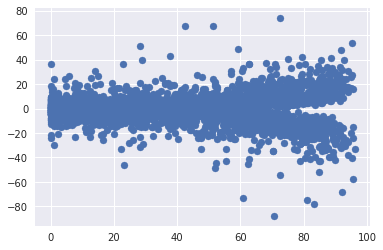

In [277]:
plt.scatter(data['fit'],data['act_point_move'])
plt.show()


In [13]:
buckets = [0,2,5,10,20,np.inf]
table = pd.crosstab(np.digitize(np.abs(data['act_point_move']), buckets), 
                    np.sign(data['act_point_move']),rownames=['bucket'])
table.index = pd.Index(['[0, 2)', '[2, 5)', '[5, 10)','[10, 20)','[20, inf)'])
table.columns = pd.Index(['bear', 'unch', 'bull'])
data[(np.sign(data['gap_up']) == 1) | (np.sign(data['gap_down']) == 1)].shape

KeyError: 'gap_up'

In [55]:
jd = data
td = jd[(jd['fit'] > 60) & (jd['fit'] < 70)]
td = data[data['act_point_move'] > 20]
td = data[(data['act_point_move'] > -10) & (data['act_point_move'] < 10)]
td = data[(data['close'] == data['open']) & (data['fit'] > 50)]
td = data[data['gap_up'] > 5]
td = data[data['fit'] >= 70]
dd = td.index.tolist()
#interact(get_candle_charts, x=dd[::-1])

#trading_days = bull_trend_days[bull_trend_days > "2015-03-01"].to_datetime().strftime('%Y-%m-%d').tolist()

array([[   5.,    5.,    4.,    6.,    3.,    9.,   21.,   26.,   35.,
          18.],
       [  15.,    9.,   21.,   14.,   21.,   38.,   47.,   76.,   79.,
          18.],
       [  70.,   47.,   37.,   48.,   50.,   58.,   74.,   68.,   43.,
           4.],
       [ 114.,   54.,   41.,   43.,   40.,   39.,   29.,   31.,    7.,
           0.],
       [ 118.,   47.,   27.,   19.,   21.,   22.,   10.,    1.,    0.,
           0.],
       [  10.,    3.,    8.,    4.,    0.,    3.,    0.,    0.,    0.,
           0.],
       [  97.,   47.,   30.,   32.,   25.,   13.,    4.,    1.,    0.,
           0.],
       [ 112.,   61.,   46.,   34.,   27.,   24.,   15.,    7.,    0.,
           0.],
       [  68.,   30.,   37.,   31.,   31.,   47.,   29.,   32.,   16.,
           0.],
       [  20.,   18.,   22.,   25.,   25.,   36.,   42.,   64.,   58.,
           8.],
       [   5.,    4.,    8.,    3.,    8.,   13.,   15.,   33.,   51.,
          17.]])

In [30]:
##CREATE DATAFRAME MAPPING TREND FIT LABELS TO RANGE VALUES
t_lb = list(range(0,100,10))
t_ub = list(range(10,110,10))
t_labels = ['[' + str(i) + ', ' + str(i+10) + ')' for i in t_lb]
t_map = pd.DataFrame(
    {'lb': t_lb,
     'ub': t_ub
    }, index=t_labels)

##CREATE DATAFRAME MAPPING CHANGE LABELS TO RANGE VALUES
c_labels = ['(-inf, -20]', '(-20, -10]', '(-10, -5]', '(-5, -2]', '(-2, 0)',
            '[0]', '(0, 2)', '[2, 5)', '[5, 10)','[10, 20)','[20, inf)'][::-1]
c_lb = [-np.inf, -20, -10, -5, -2, -0.1, 0.1, 2, 5, 10, 20][::-1]
c_ub = [-20, -10, -5, -2, -0.1, 0.1, 2, 5, 10, 20, np.inf][::-1]
c_map = pd.DataFrame(
    {'lb': c_lb,
     'ub': c_ub
    }, index=c_labels)


/home/vagrant/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


DatetimeIndex(['2005-09-07 16:15:00-04:00', '2005-09-08 16:15:00-04:00',
               '2005-09-09 16:15:00-04:00', '2005-09-12 16:15:00-04:00',
               '2005-09-13 16:15:00-04:00', '2005-09-14 16:15:00-04:00',
               '2005-09-15 16:15:00-04:00', '2005-09-16 16:15:00-04:00',
               '2005-09-19 16:15:00-04:00', '2005-09-20 16:15:00-04:00',
               ...
               '2017-10-13 16:15:00-04:00', '2017-10-16 16:15:00-04:00',
               '2017-10-17 16:15:00-04:00', '2017-10-18 16:15:00-04:00',
               '2017-10-19 16:15:00-04:00', '2017-10-20 16:15:00-04:00',
               '2017-10-23 16:15:00-04:00', '2017-10-24 16:15:00-04:00',
               '2017-10-25 16:15:00-04:00', '2017-10-26 16:15:00-04:00'],
              dtype='datetime64[ns, US/Eastern]', length=3031, freq=None)

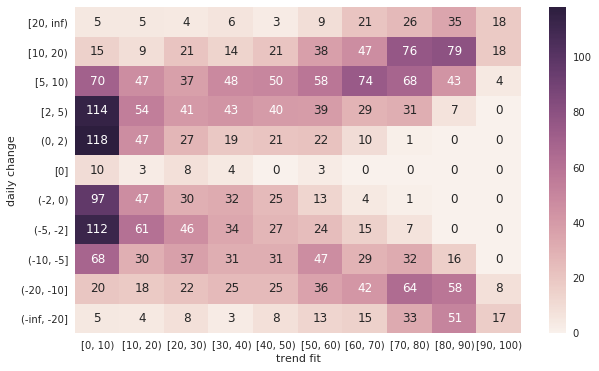

In [31]:
##CREATE HEATMAP - TREND FIT VS CHANGE
xedges = range(0,110,10)
yedges = [0,2,5,10,20,np.inf]

##bear days
cond = (np.sign(data['act_point_move']) == -1)
xdata = data[cond]['fit']
ydata = abs(data[cond]['act_point_move'])
H1, xedges, yedges = np.histogram2d(xdata, ydata, bins=(xedges, yedges))

##bull days
cond = (np.sign(data['act_point_move']) == 1)
xdata = data[cond]['fit']
ydata = abs(data[cond]['act_point_move'])
H2, xedges, yedges = np.histogram2d(xdata, ydata, bins=(xedges, yedges))

##unch days
cond = (np.sign(data['act_point_move']) == 0)
xdata = data[cond]['fit']
ydata = abs(data[cond]['act_point_move'])
H3, xedges, yedges = np.histogram2d(xdata, ydata, bins=(xedges, yedges))

#create numpy array and dataframe with all data
arr = np.append(
        np.append(np.flipud(H2.T), H3.T[:1], axis=0), H1.T, axis=0)
heatmap_data = pd.DataFrame(arr)
heatmap_data.index = pd.Index(c_labels, name='daily change')
heatmap_data.columns = pd.Index(t_labels, name='trend fit')

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f")

heatmap_data.sum(axis=0)
#heatmap_data.sum(axis=1)
data.index

In [16]:
summary_stats = pd.DataFrame(columns=['avg_price', 'avg_daily_range', 'trading_days', 'bull_trend', 'bear_trend',
                                     'trend_pct', 'gap_up', 'gap_down', 'gap_pct', 'gu_bull', 'gu_bear', 'gd_bull',
                                     'gd_bear', 'gt_pct'])
years = range(2005,2018,1)
for year in years:
    yearly_data = data[str(year)]
    avg_price = round(yearly_data['close'].mean())
    avg_daily_range = round(yearly_data['range'].mean(),2)
    trading_days = yearly_data.shape[0]
    fit_70_and_up = yearly_data['fit'] >= 70
    fit_50_to_70 = (yearly_data['fit'] >= 50) & (yearly_data['fit'] < 70)
    close_up_5 = yearly_data['act_point_move'] >= 5
    close_down_5 = yearly_data['act_point_move'] <= -5
    gap_above_high = np.sign(yearly_data['open-prev_high']) == 1
    gap_below_low = np.sign(yearly_data['prev_low-open']) == 1
    up_5_on = yearly_data['open-prev_close'] >= 5
    down_5_on = yearly_data['open-prev_close'] <= -5
    
    bull_trend = yearly_data[fit_70_and_up & close_up_5].shape[0]
    bear_trend = yearly_data[fit_70_and_up & close_down_5].shape[0]
    trend_pct = round((((bull_trend + bear_trend) / trading_days) * 100),2)
    gap_up = yearly_data[gap_above_high].shape[0]
    gap_down = yearly_data[gap_below_low].shape[0]
    gap_pct = round((((gap_up + gap_down) / trading_days) * 100),2)
    gu_bull = yearly_data[gap_above_high & fit_70_and_up & close_up_5].shape[0]
    gu_bear = yearly_data[gap_above_high & fit_70_and_up & close_down_5].shape[0]
    gd_bull = yearly_data[gap_below_low & fit_70_and_up & close_up_5].shape[0]
    gd_bear = yearly_data[gap_below_low & fit_70_and_up & close_down_5].shape[0]
    gt_pct = round((((gu_bull + gu_bear + gd_bull + gd_bear) / (gap_up + gap_down)) * 100),2)
    
    
    
    summary_stats.loc[year] = [avg_price, avg_daily_range, trading_days, bull_trend, bear_trend, trend_pct,
                              gap_up, gap_down, gap_pct, gu_bull, gu_bear, gd_bull, gd_bear, gt_pct]
    
summary_stats['avg_price'] = summary_stats['avg_price'].astype(np.int64)
summary_stats['trading_days'] = summary_stats['trading_days'].astype(np.int64)
summary_stats

,avg_price,avg_daily_range,trading_days,bull_trend,bear_trend,trend_pct,gap_up,gap_down,gap_pct,gu_bull,gu_bear,gd_bull,gd_bear,gt_pct
2005,1135,11.15,80,11.0,12.0,28.75,12.0,6.0,22.50,1.0,2.0,2.0,1.0,33.33
2006,1193,11.45,249,21.0,23.0,17.67,31.0,26.0,22.89,5.0,1.0,2.0,3.0,19.30
2007,1312,17.28,248,27.0,21.0,19.35,44.0,33.0,31.05,5.0,1.0,2.0,6.0,18.18
2008,1021,31.23,250,26.0,42.0,27.20,40.0,51.0,36.40,3.0,7.0,7.0,9.0,28.57
2009,746,17.74,250,26.0,26.0,20.80,52.0,42.0,37.60,5.0,3.0,3.0,5.0,17.02
2010,956,15.09,251,29.0,13.0,16.73,63.0,37.0,39.84,5.0,5.0,4.0,3.0,17.00
2011,1104,18.55,251,32.0,26.0,23.11,66.0,40.0,42.23,9.0,4.0,5.0,4.0,20.75
2012,1238,13.73,247,29.0,24.0,21.46,59.0,43.0,41.30,5.0,9.0,7.0,2.0,22.55
2013,1526,13.64,249,29.0,15.0,17.67,59.0,27.0,34.54,5.0,3.0,5.0,2.0,17.44
2014,1839,16.63,249,31.0,22.0,21.29,60.0,34.0,37.75,8.0,6.0,3.0,3.0,21.28


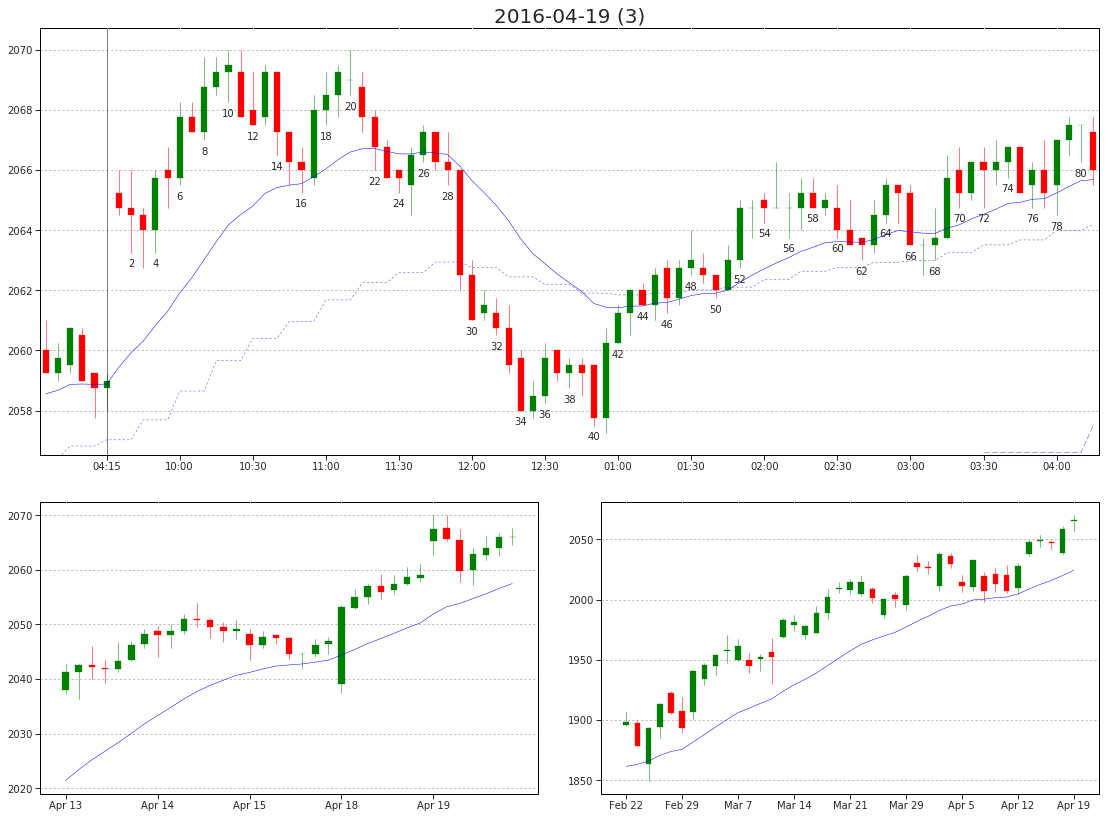

In [32]:
t_w = widgets.SelectMultiple(
    options=t_map.index.tolist(),
    value=[t_map.index.tolist()[0]],
    description='Trend Fit',
    layout=widgets.Layout(height='190px'),
    disabled=False
)


c_w = widgets.SelectMultiple(
    options=c_map.index.tolist(),
    value=[c_map.index.tolist()[0]],
    description='Change',
    layout=widgets.Layout(height='190px'),
    disabled=False
)

button = widgets.Button(description="Get Trading Days")
display(widgets.HBox([t_w, c_w, button]))

def on_button_clicked(b):
    first = True
    for i in t_w.value:
        filter1 = (data['fit'] >= t_map.loc[i].lb) & (data['fit'] < t_map.loc[i].ub)
        if first:
            first = False
            query1 = filter1
        else:
            query1 = query1 | filter1
            
    first = True
    for i in c_w.value:
        if np.sign(c_map.loc[i].lb) == 1:
            filter2 = (data['act_point_move'] >= c_map.loc[i].lb) & (data['act_point_move'] < c_map.loc[i].ub)
        else:
            filter2 = (data['act_point_move'] > c_map.loc[i].lb) & (data['act_point_move'] <= c_map.loc[i].ub)
        
        if first:
            first = False
            query2 = filter2
        else:
            query2 = query2 | filter2
            
    query3 = data['open-prev_close'] >= 5
    
    d = data[query1 & query2 & query3]
    #d = d['2017']
    dates = []
    for date in d.index.tolist():
        fit = int(round(d.loc[date]['fit']))
        dates.append(date.strftime('%Y-%m-%d') + ' (' + str(fit) + ')')

    #date_widget.observe(on_value_change, names='value')
    #display(date_widget)
    interact(get_candle_charts, plot_title=dates[::-1])

button.on_click(on_button_clicked)

/home/vagrant/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


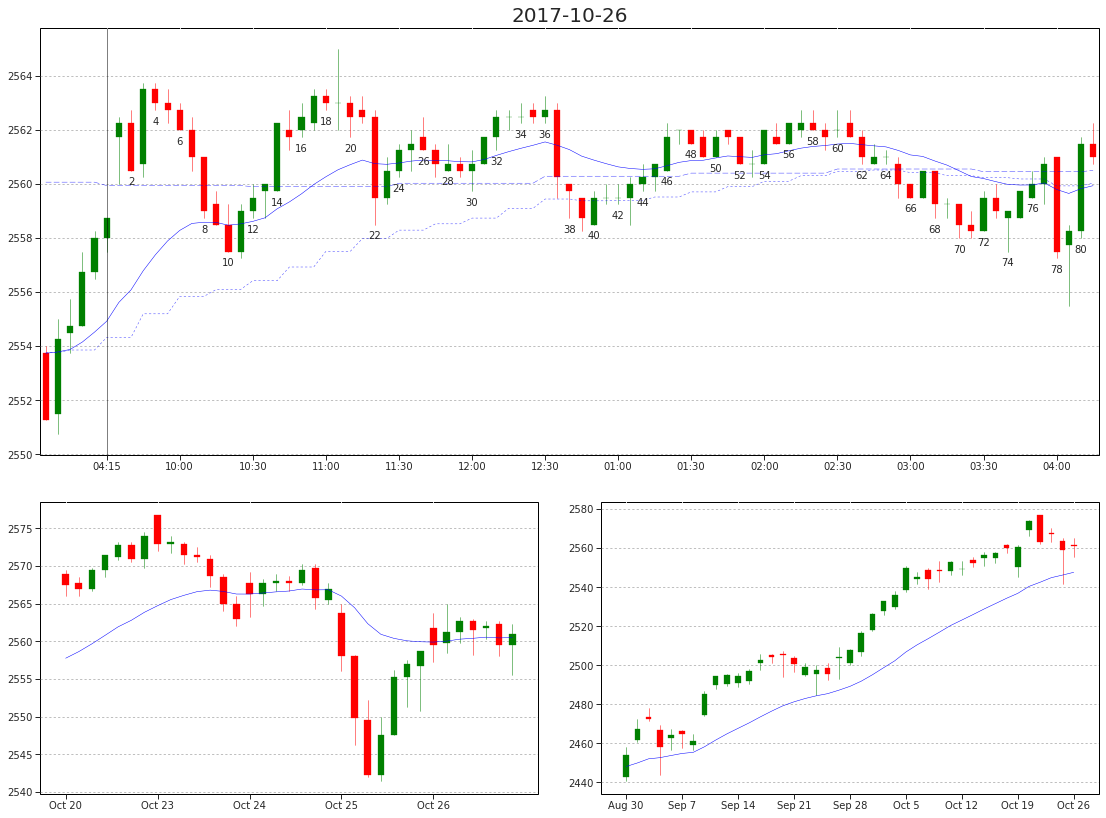

In [32]:
#data.loc['2016-06-24']
get_candle_charts('2017-10-26')

In [18]:
def print_candle_charts(filename, titles):
    slices = list(range(0,len(titles),100))
    num_slices = len(slices)
    for i in range(num_slices):
        fn = filename + "-" + str(i+1) + '.pdf'
        pdf_pages = PdfPages(fn)
        if i == num_slices-1:
            titles_sliced = titles[slices[i]:]
        else:
            titles_sliced = titles[slices[i]:slices[i+1]]
        
        for title in titles_sliced:
            plot_candlesticks(title,create_candlesticks(title.split()[0]),pdf_pages)
        pdf_pages.close()
        sleep(60)
    

q = (data['fit'] >= 70) & (data['act_point_move'] <= -5)
dates = []
for date in data[41:].index.tolist():
    #dates.append(date.strftime('%Y-%m-%d'))
    fit = int(round(data.loc[date]['fit']))
    dates.append(date.strftime('%Y-%m-%d') + ' (' + str(fit) + ')')
dates = dates[::-1]

#print_candle_charts('strong-trend',dates)

slices = list(range(0,len(dates),100))
num_slices = len(slices)
filename = 'trading-days'
i = 1
fn = filename + "-" + str(i+1) + '.pdf'
pdf_pages = PdfPages(fn)
if i == num_slices-1:
    titles_sliced = dates[slices[i]:]
else:
    titles_sliced = dates[slices[i]:slices[i+1]]
        
for title in titles_sliced:
    plot_candlesticks(title,create_candlesticks(title.split()[0]),pdf_pages)
pdf_pages.close()



/home/vagrant/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [22]:
data[41:]

,open,close,high,low,open-prev_high,prev_low-open,open-prev_close,slope,fit,bars,imp_pct_move,imp_point_move,act_pct_move,act_point_move,range
2005-11-03 16:15:00-05:00,1125.50,1127.00,1131.00,1121.75,3.75,-19.75,4.00,-0.035837,20.975011,81,-0.257913,-2.902806,0.133274,1.50,9.25
2005-11-04 16:15:00-05:00,1128.25,1125.25,1128.75,1119.75,-2.75,-6.50,1.25,-0.014943,3.525122,81,-0.107281,-1.210403,-0.265899,-3.00,9.00
2005-11-07 16:15:00-05:00,1128.25,1126.25,1130.25,1122.50,-0.50,-8.50,3.00,0.041502,36.152404,81,0.297954,3.361666,-0.177266,-2.00,7.75
2005-11-08 16:15:00-05:00,1123.25,1126.00,1127.75,1121.75,-7.00,-0.75,-3.00,0.024981,26.114888,81,0.180141,2.023435,0.244825,2.75,6.00
2005-11-09 16:15:00-05:00,1124.25,1127.00,1132.75,1122.00,-3.50,-2.50,-1.75,0.075127,38.955644,81,0.541276,6.085292,0.244608,2.75,10.75
2005-11-10 16:15:00-05:00,1126.75,1137.25,1138.75,1120.50,-6.00,-4.75,-0.25,0.214114,77.318034,81,1.539226,17.343227,0.931884,10.50,18.25
2005-11-11 16:15:00-05:00,1137.00,1141.25,1142.00,1136.25,-1.75,-16.50,-0.25,0.038719,71.842920,81,0.275831,3.136203,0.373791,4.25,5.75
2005-11-14 16:15:00-05:00,1141.00,1140.50,1143.50,1137.25,-1.00,-4.75,-0.25,-0.025446,32.688268,81,-0.180642,-2.061123,-0.043821,-0.50,6.25
2005-11-15 16:15:00-05:00,1139.00,1135.75,1144.25,1131.75,-4.50,-1.75,-1.50,-0.069693,26.732437,81,-0.495625,-5.645166,-0.285338,-3.25,12.50
2005-11-16 16:15:00-05:00,1136.75,1138.00,1138.50,1132.50,-7.50,-5.00,1.00,0.014758,9.199697,81,0.105161,1.195416,0.109963,1.25,6.00


In [250]:
five_min_bars = five_min.loc['2017-01-27']
#create a fake bar 0 to account for open of day
bar0 = pd.DataFrame([[five_min_bars.iloc[0].open, 0]], columns=['close', 'barcount'])
#data = pd.concat([bar0, five_min_bars], join='inner')
#regression = ols('close ~ barcount', data=data).fit()
bar0

,close,barcount
0,2293.75,0


In [24]:
five_min_bars = five_min.loc['2017-06-13']
#chart_data['gap_down'] = chart_data.shift(1)['low'] - chart_data['open']
five_min_bars['close_above'] = five_min_bars['close'] >= five_min_bars.shift(1)['close']
five_min_bars['low_above'] = five_min_bars['low'] >= five_min_bars.shift(1)['low']
five_min_bars['close_below'] = five_min_bars['close'] <= five_min_bars.shift(1)['close']
five_min_bars['high_below'] = five_min_bars['high'] <= five_min_bars.shift(1)['high']
del five_min_bars['60min_ema']
del five_min_bars['15min_ema']
five_min_bars

,volume,open,close,high,low,bartimer,barcount,ema,close_above,low_above,close_below,high_below
2017-06-13 09:35:00-04:00,34838,2431.25,2431.50,2432.25,2430.75,00:05:00,1,2423.195750,False,False,False,False
2017-06-13 09:40:00-04:00,30656,2431.50,2431.75,2432.25,2430.50,00:10:00,2,2424.010440,True,False,False,True
2017-06-13 09:45:00-04:00,24427,2432.00,2433.75,2434.00,2431.75,00:15:00,3,2424.938017,True,True,False,False
2017-06-13 09:50:00-04:00,21450,2433.75,2432.75,2434.25,2432.25,00:20:00,4,2425.682016,False,True,True,False
2017-06-13 09:55:00-04:00,26376,2432.75,2432.00,2433.00,2430.75,00:25:00,5,2426.283728,False,False,True,True
2017-06-13 10:00:00-04:00,18336,2432.00,2432.00,2432.50,2430.75,00:30:00,6,2426.828135,True,True,True,True
2017-06-13 10:05:00-04:00,18910,2432.00,2430.50,2432.25,2430.50,00:35:00,7,2427.177837,False,False,True,True
2017-06-13 10:10:00-04:00,23113,2430.50,2430.75,2432.00,2430.25,00:40:00,8,2427.518043,True,False,False,True
2017-06-13 10:15:00-04:00,31539,2430.75,2431.25,2432.50,2430.50,00:45:00,9,2427.873467,True,True,False,False
2017-06-13 10:20:00-04:00,15771,2431.25,2430.50,2431.50,2430.00,00:50:00,10,2428.123613,False,False,True,True


In [25]:
five_min_bars['swings'] = np.nan
diff = 4 #Number of points for swing

pivot = five_min_bars.iloc[0].open
init_swing_low = pivot
init_swing_high = pivot
last_pivot_id = 0
up_down = 0

data = five_min_bars.copy()

for i, row in data.iterrows():
    # We don't have a trend yet
    if up_down == 0:
        if row.low <= init_swing_high - diff:
            data.ix[i, 'swings'] = row.low - init_swing_high
            pivot, last_pivot_id = row.low, i
            up_down = -1
        elif row.high >= init_swing_low + diff:
            data.ix[i, 'swings'] = row.high - init_swing_low
            pivot, last_pivot_id = row.high, i
            up_down = 1
            
        if row.low < init_swing_low:
            init_swing_low = row.low
        if row.high > init_swing_high:
            init_swing_high = row.high
            
    # Current trend is up
    elif up_down == 1:
        # If got higher than last pivot, update the swing
        if row.high >= pivot:
            # Remove the last pivot, as it wasn't a real one
            data.ix[i, 'swings'] = data.ix[last_pivot_id, 'swings'] + (row.high - data.ix[last_pivot_id, 'high'])
            data.ix[last_pivot_id, 'swings'] = np.nan
            pivot, last_pivot_id = row.high, i
        elif row.low <= pivot - diff:
            data.ix[i, 'swings'] = row.low - pivot
            pivot, last_pivot_id = row.low, i
            # Change the trend indicator
            up_down = -1
            
    # Current trend is down
    elif up_down == -1:
        # If got lower than last pivot, update the swing
        if row.low <= pivot:
            # Remove the last pivot, as it wasn't a real one
            data.ix[i, 'swings'] = data.ix[last_pivot_id, 'swings'] + (row.low - data.ix[last_pivot_id, 'low'])
            data.ix[last_pivot_id, 'swings'] = np.nan
            pivot, last_pivot_id = row.low, i
        elif row.high >= pivot + diff:
            data.ix[i, 'swings'] = row.high - pivot
            pivot, last_pivot_id = row.high, i
            # Change the trend indicator
            up_down = 1

    print([row['barcount'], pivot, up_down])

[1, 2431.25, 0]
[2, 2431.25, 0]
[3, 2431.25, 0]
[4, 2431.25, 0]
[5, 2431.25, 0]
[6, 2431.25, 0]
[7, 2431.25, 0]
[8, 2430.25, -1]
[9, 2430.25, -1]
[10, 2430.0, -1]
[11, 2430.0, -1]
[12, 2430.0, -1]
[13, 2430.0, -1]
[14, 2430.0, -1]
[15, 2430.0, -1]
[16, 2429.75, -1]
[17, 2429.25, -1]
[18, 2427.75, -1]
[19, 2427.0, -1]
[20, 2427.0, -1]
[21, 2427.0, -1]
[22, 2431.0, 1]
[23, 2431.25, 1]
[24, 2431.25, 1]
[25, 2431.25, 1]
[26, 2431.25, 1]
[27, 2433.25, 1]
[28, 2433.5, 1]
[29, 2433.5, 1]
[30, 2433.5, 1]
[31, 2433.5, 1]
[32, 2433.5, 1]
[33, 2433.5, 1]
[34, 2433.5, 1]
[35, 2433.5, 1]
[36, 2433.5, 1]
[37, 2433.5, 1]
[38, 2433.75, 1]
[39, 2435.0, 1]
[40, 2435.0, 1]
[41, 2435.0, 1]
[42, 2435.25, 1]
[43, 2435.25, 1]
[44, 2435.25, 1]
[45, 2436.0, 1]
[46, 2436.0, 1]
[47, 2436.0, 1]
[48, 2436.0, 1]
[49, 2436.0, 1]
[50, 2436.0, 1]
[51, 2436.0, 1]
[52, 2436.0, 1]
[53, 2436.0, 1]
[54, 2436.0, 1]
[55, 2436.0, 1]
[56, 2436.75, 1]
[57, 2436.75, 1]
[58, 2436.75, 1]
[59, 2436.75, 1]
[60, 2436.75, 1]
[61, 2436

In [26]:
with pd.option_context('display.max_rows', None):
    display(data)

,volume,open,close,high,low,bartimer,barcount,ema,close_above,low_above,close_below,high_below,swings
2017-06-13 09:35:00-04:00,34838,2431.25,2431.50,2432.25,2430.75,00:05:00,1,2423.195750,False,False,False,False,NaN
2017-06-13 09:40:00-04:00,30656,2431.50,2431.75,2432.25,2430.50,00:10:00,2,2424.010440,True,False,False,True,NaN
2017-06-13 09:45:00-04:00,24427,2432.00,2433.75,2434.00,2431.75,00:15:00,3,2424.938017,True,True,False,False,NaN
2017-06-13 09:50:00-04:00,21450,2433.75,2432.75,2434.25,2432.25,00:20:00,4,2425.682016,False,True,True,False,NaN
2017-06-13 09:55:00-04:00,26376,2432.75,2432.00,2433.00,2430.75,00:25:00,5,2426.283728,False,False,True,True,NaN
2017-06-13 10:00:00-04:00,18336,2432.00,2432.00,2432.50,2430.75,00:30:00,6,2426.828135,True,True,True,True,NaN
2017-06-13 10:05:00-04:00,18910,2432.00,2430.50,2432.25,2430.50,00:35:00,7,2427.177837,False,False,True,True,NaN
2017-06-13 10:10:00-04:00,23113,2430.50,2430.75,2432.00,2430.25,00:40:00,8,2427.518043,True,False,False,True,NaN
2017-06-13 10:15:00-04:00,31539,2430.75,2431.25,2432.50,2430.50,00:45:00,9,2427.873467,True,True,False,False,NaN
2017-06-13 10:20:00-04:00,15771,2431.25,2430.50,2431.50,2430.00,00:50:00,10,2428.123613,False,False,True,True,NaN


In [627]:
from scipy.signal import argrelmin, argrelmax
h = five_min_bars['high'].dropna().copy() # make a series of Highs
l = five_min_bars['low'].dropna().copy()  # make a series of Lows
argrelmax(h.values)[0]

array([ 3,  8, 16, 20, 23, 26, 29, 34, 37, 40, 46, 50, 57, 63, 78])